# Introduction

trackintel documentation: https://trackintel.readthedocs.io/en/latest/modules/model.html#trackintel.Positionfixes

trackintel tutorial: https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb

In [4]:
import geopandas as gpd
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta
from matplotlib import pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point

import trackintel as ti

In [5]:
cityA = pd.read_csv('cityA_groundtruthdata.csv.gz', compression='gzip')
cityA.head()

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89


,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89


In [6]:
cityA.shape

(111535175, 5)

(111535175, 5)

In [7]:
cityA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111535175 entries, 0 to 111535174
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 4.2 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111535175 entries, 0 to 111535174
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 4.2 GB


`d`: Days since start of the data collection, ranges from 0-74 (the data is collected over 75 days)   
`t`: Ranges from 0-47 (the data is collected every 30 mins, there is 48 such periods in 1 day)

# Data Preprocessing

Limit the data to only the first month's data (30 days), i.e. `d` < 30.

In [11]:
cityA = cityA[cityA['d'] < 30]

In [12]:
cityA.shape

(43679653, 5)

(43679653, 5)

Here, we define an arbitrary start date of the data collected.

In [14]:
# Define the start date
start_date = pd.to_datetime("2024-01-01")

In [15]:
def preprocess_data(data, start_date):
    # Create Point geometries
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    gdf.set_crs(epsg=3857, inplace=True)

    # Convert 'd' (days since start) to actual date
    gdf['date'] = start_date + pd.to_timedelta(gdf['d'], unit='D')
    
    # Convert 't' (30-minute intervals) to time of day
    gdf['time'] = pd.to_timedelta(gdf['t'] * 30, unit='m')  # Each 't' is multiplied by 30 minutes
    
    # Combine 'date' and 'time' into a single datetime column
    gdf['datetime'] = gdf['date'] + gdf['time']

    return gdf

In [16]:
cityA_processed = preprocess_data(cityA, start_date)

In [17]:
cityA_processed.head()

,uid,d,t,x,y,geometry,date,time,datetime
0,0,0,1,79,86,POINT (79.000 86.000),2024-01-01,0 days 00:30:00,2024-01-01 00:30:00
1,0,0,2,79,86,POINT (79.000 86.000),2024-01-01,0 days 01:00:00,2024-01-01 01:00:00
2,0,0,8,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:00:00,2024-01-01 04:00:00
3,0,0,9,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:30:00,2024-01-01 04:30:00
4,0,0,19,81,89,POINT (81.000 89.000),2024-01-01,0 days 09:30:00,2024-01-01 09:30:00


,uid,d,t,x,y,geometry,date,time,datetime
0,0,0,1,79,86,POINT (79.000 86.000),2024-01-01,0 days 00:30:00,2024-01-01 00:30:00
1,0,0,2,79,86,POINT (79.000 86.000),2024-01-01,0 days 01:00:00,2024-01-01 01:00:00
2,0,0,8,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:00:00,2024-01-01 04:00:00
3,0,0,9,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:30:00,2024-01-01 04:30:00
4,0,0,19,81,89,POINT (81.000 89.000),2024-01-01,0 days 09:30:00,2024-01-01 09:30:00


In [18]:
cityA_processed.shape

(43679653, 9)

(43679653, 9)

In [19]:
pfsA = ti.io.read_positionfixes_gpd(cityA_processed, tracked_at="datetime", user_id="uid", geom_col="geometry", tz='Asia/Tokyo')

In [20]:
pfsA.head()

,user_id,d,t,x,y,geometry,date,time,tracked_at
0,0,0,1,79,86,POINT (79.000 86.000),2024-01-01,0 days 00:30:00,2024-01-01 00:30:00+09:00
1,0,0,2,79,86,POINT (79.000 86.000),2024-01-01,0 days 01:00:00,2024-01-01 01:00:00+09:00
2,0,0,8,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:00:00,2024-01-01 04:00:00+09:00
3,0,0,9,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:30:00,2024-01-01 04:30:00+09:00
4,0,0,19,81,89,POINT (81.000 89.000),2024-01-01,0 days 09:30:00,2024-01-01 09:30:00+09:00


,user_id,d,t,x,y,geometry,date,time,tracked_at
0,0,0,1,79,86,POINT (79.000 86.000),2024-01-01,0 days 00:30:00,2024-01-01 00:30:00+09:00
1,0,0,2,79,86,POINT (79.000 86.000),2024-01-01,0 days 01:00:00,2024-01-01 01:00:00+09:00
2,0,0,8,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:00:00,2024-01-01 04:00:00+09:00
3,0,0,9,77,86,POINT (77.000 86.000),2024-01-01,0 days 04:30:00,2024-01-01 04:30:00+09:00
4,0,0,19,81,89,POINT (81.000 89.000),2024-01-01,0 days 09:30:00,2024-01-01 09:30:00+09:00


In [21]:
pfsA.shape

(43679653, 9)

(43679653, 9)

# 1. Staypoints Generation

In [23]:
gap_threshold = 45  # minutes between position fixes to consider a new staypoint
dist_threshold = 10  # distance threshold to be considered a new staypoint (each unit represents 500 metres) 
pfsA, spA = pfsA.as_positionfixes.generate_staypoints(gap_threshold=gap_threshold, dist_threshold=dist_threshold, print_progress=True)

 13%|█████████▍                                                                | 12715/99749 [19:57<2:02:37, 11.83it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 21%|███████████████▎                                                          | 20577/99749 [29:52<1:59:19, 11.06it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 24%|█████████████████▌                                                        | 23701/99749 [33:52<1:45:56, 11.96it/s]

In [24]:
spA.head()

,user_id,started_at,finished_at,geometry
id,,,,
0,0,2024-01-01 09:30:00+09:00,2024-01-01 10:00:00+09:00,POINT (81.000 89.000)
1,0,2024-01-01 10:00:00+09:00,2024-01-01 10:30:00+09:00,POINT (82.000 88.000)
2,0,2024-01-01 12:00:00+09:00,2024-01-01 12:30:00+09:00,POINT (76.000 86.000)
3,0,2024-01-01 14:30:00+09:00,2024-01-01 15:00:00+09:00,POINT (76.000 83.000)
4,0,2024-01-01 21:00:00+09:00,2024-01-01 21:30:00+09:00,POINT (79.000 106.000)


In [25]:
spA.shape

(23697856, 4)

# 2. Triplegs Generation

In [27]:
pfsA, tplsA = pfsA.generate_triplegs(staypoints=spA, method='overlap_staypoints', gap_threshold=45)

C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:573: UserWarning: The positionfixes with ids [     

In [28]:
tplsA.head()

,user_id,started_at,finished_at,geom
id,,,,
2,0,2024-01-01 10:30:00+09:00,2024-01-01 11:00:00+09:00,"LINESTRING (82.000 88.000, 81.000 89.000, 81.0..."
3,0,2024-01-03 19:00:00+09:00,2024-01-03 19:30:00+09:00,"LINESTRING (76.000 84.000, 77.000 86.000, 77.0..."
4,0,2024-01-05 18:00:00+09:00,2024-01-05 18:30:00+09:00,"LINESTRING (81.000 88.000, 77.000 86.000, 77.0..."
7,0,2024-01-16 19:00:00+09:00,2024-01-16 19:30:00+09:00,"LINESTRING (77.000 84.000, 77.000 86.000, 77.0..."
8,0,2024-01-17 08:30:00+09:00,2024-01-17 09:30:00+09:00,"LINESTRING (76.000 87.000, 77.000 86.000, 77.0..."


In [29]:
tplsA.shape

(912566, 4)

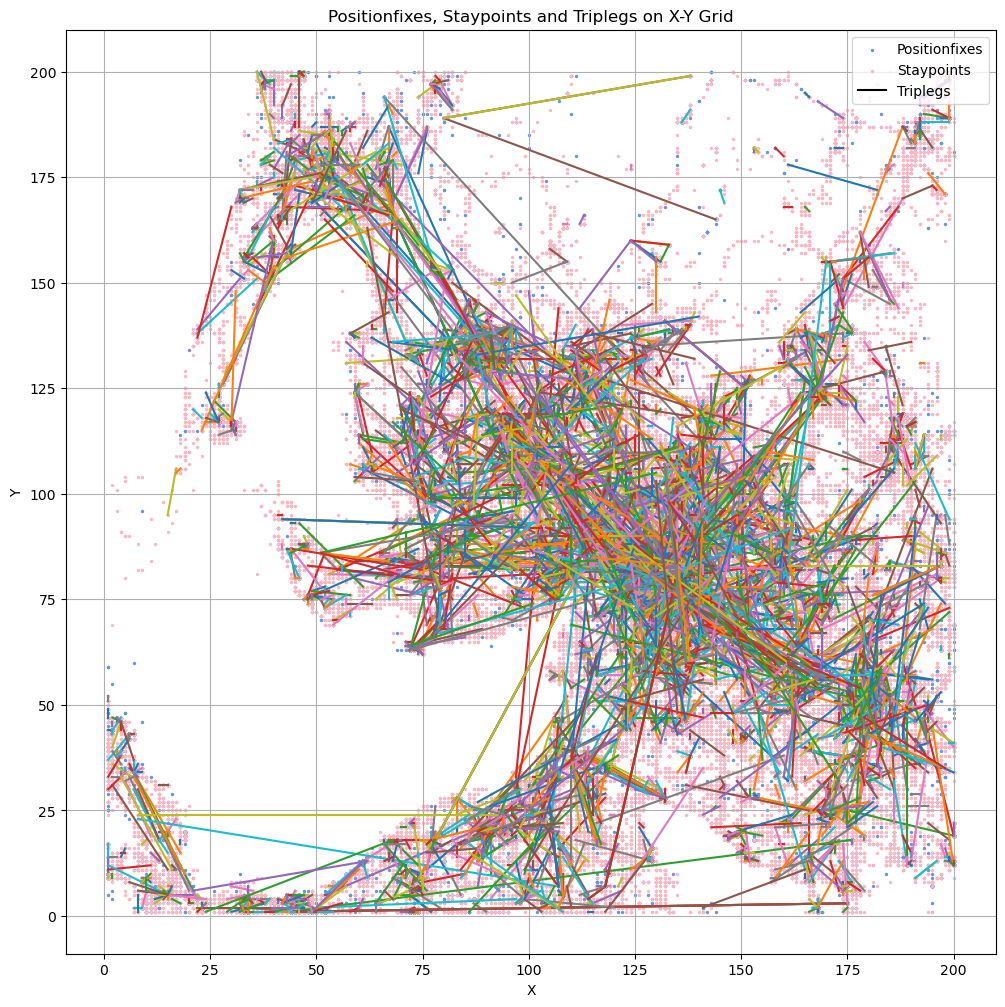

In [30]:
# Plot only part of the data due to large dataset
pfsA_plot = pfsA[:500000]
staypoints = pfsA_plot.dropna(subset=['staypoint_id'])
positionfixes = pfsA_plot[pfsA_plot['staypoint_id'].isna()]

# Plot on x-y grid
plt.figure(figsize=(12, 12))
plt.scatter(positionfixes['x'], positionfixes['y'], label='Positionfixes', color='#6495ED', s=2)
plt.scatter(staypoints['x'], staypoints['y'], label='Staypoints', color='#FFB6C1', s=2)

# Plot triplegs by connecting positionfixes with the same tripleg_id
for i, (tripleg_id, tripleg_data) in enumerate(pfsA_plot.dropna(subset=['tripleg_id']).groupby('tripleg_id')):
    plt.plot(tripleg_data['x'], tripleg_data['y'], linestyle='-')

# Add a single legend entry for all triplegs
plt.plot([], [], linestyle='-', color='black', label='Triplegs')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Positionfixes, Staypoints and Triplegs on X-Y Grid')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()